<a href="https://colab.research.google.com/github/micahks/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/Micah_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

#Data Wrangling

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [ ]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [ ]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#change the created column to at date_time object and removed the time.

df['created'] = pd.to_datetime(df['created']).dt.date

df['created'] = pd.to_datetime(df['created'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48817 entries, 0 to 49351
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   bathrooms             48817 non-null  float64       
 1   bedrooms              48817 non-null  int64         
 2   created               48817 non-null  datetime64[ns]
 3   description           47392 non-null  object        
 4   display_address       48684 non-null  object        
 5   latitude              48817 non-null  float64       
 6   longitude             48817 non-null  float64       
 7   price                 48817 non-null  int64         
 8   street_address        48807 non-null  object        
 9   interest_level        48817 non-null  object        
 10  elevator              48817 non-null  int64         
 11  cats_allowed          48817 non-null  int64         
 12  hardwood_floors       48817 non-null  int64         
 13  dogs_allowed    

In [ ]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#set index to the created column

df = df.set_index('created').sort_values('created')

In [ ]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01,1.0,1,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,40.7939,-73.9738,2745,700 West End Ave,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02,1.0,3,"<![CDATA[2 bedrooms, 1800, Bedford Stuyvesant/...",Fulton Street,40.6798,-73.9414,1800,1490 Fulton Street,high,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Create new features

In [ ]:
#creating new columns for feature engineering

df['amenity_score'] = df[['elevator',
                          'cats_allowed',
                          'hardwood_floors',
                          'dogs_allowed',
                          'doorman',
                        	'dishwasher',
                          'no_fee',
                          'laundry_in_building',
                          'fitness_center',
 #                         'pre-war',
                          'laundry_in_unit',
                          'roof_deck',
                          'outdoor_space',
                          'dining_room',
                          'high_speed_internet',
                          'balcony',
                          'swimming_pool',
                        	'new_construction',
                          'terrace',
                        	'exclusive',
                          'loft',
                          'garden_patio',
                          'wheelchair_access',
                          'common_outdoor_space']].sum(axis=1)


df['interest_score'] = df['interest_level'].map({'low': 1, 'medium': 2, 'high':3})
df['description_char'] = df['description'].str.len()
df['description_char'] = df['description_char'].fillna(0)
df['lat/lon'] = df['latitude']*df['longitude']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-04-01 to 2016-06-29
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-null  int64  
 15  no

## Plots

In [ ]:
bathrooms = 'bathrooms'
bedrooms = 'bedrooms'
description = 'description_char'
lat = 'latitude'
lon = 'longitude'
interest = 'interest_score'
amenities = 'amenity_score'
price = 'price'

In [ ]:
df[description]

created
2016-04-01    816.0
2016-04-01     94.0
2016-04-01    357.0
2016-04-01    411.0
2016-04-02    375.0
              ...  
2016-06-29    417.0
2016-06-29    956.0
2016-06-29    351.0
2016-06-29    503.0
2016-06-29    225.0
Name: description_char, Length: 48817, dtype: float64

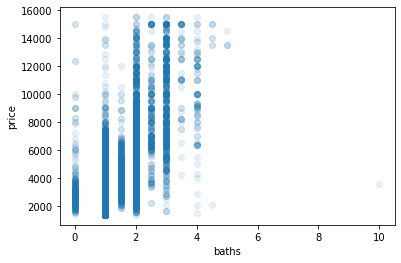

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df[bathrooms], df[price], alpha=.1)
plt.xlabel('baths')
plt.ylabel('price');

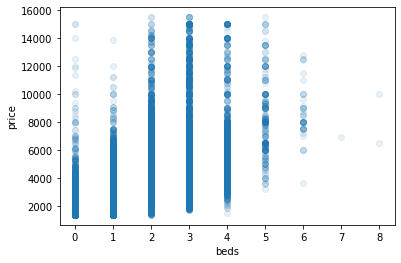

In [ ]:
plt.scatter(df[bedrooms], df[price], alpha=.1)
plt.xlabel('beds')
plt.ylabel('price');

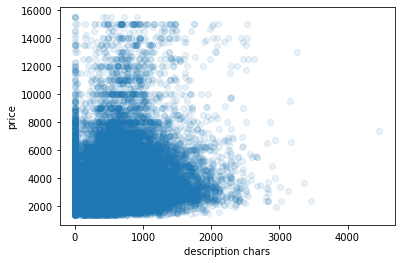

In [ ]:
plt.scatter(df[description], df[price], alpha=.1)
plt.xlabel('description chars')
plt.ylabel('price');

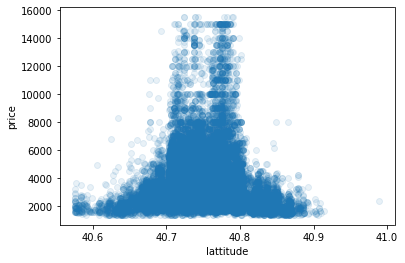

In [ ]:
plt.scatter(df[lat], df[price], alpha=.1)
plt.xlabel('lattitude')
plt.ylabel('price');

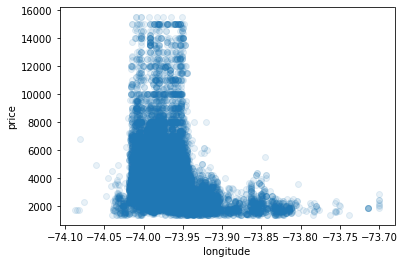

In [ ]:
plt.scatter(df[lon], df[price], alpha=.1)
plt.xlabel('longitude')
plt.ylabel('price');

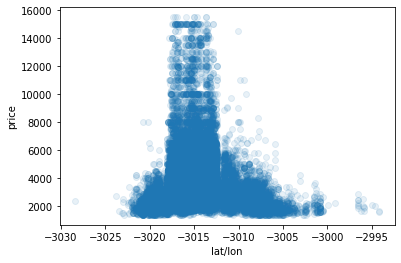

In [ ]:
plt.scatter(df[latlon], df[price], alpha=.1)
plt.xlabel('lat/lon')
plt.ylabel('price');

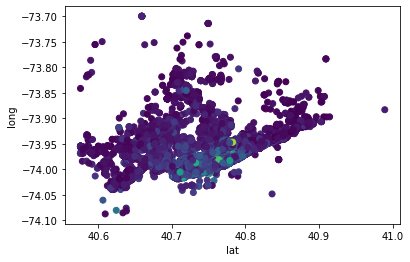

In [ ]:
#for my own curiosity, I wanted to see where the expesive rentals are in relation to eachother. 

plt.scatter(df[lat], df[lon], c=df[price])
plt.xlabel('lat')
plt.ylabel('long');

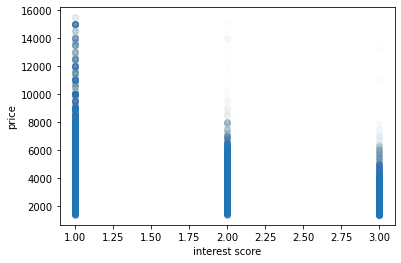

In [ ]:
plt.scatter(df[interest], df[price], alpha=.01)
plt.xlabel('interest score')
plt.ylabel('price');

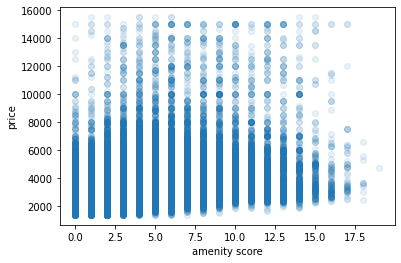

In [ ]:
plt.scatter(df[amenities], df[price], alpha=.1)
plt.xlabel('amenity score')
plt.ylabel('price');

# Specify Target vector and feature maxtix

In [ ]:
y = df[price]
X = df[[bathrooms, 
        bedrooms, 
        description, 
        lat, 
        lon, 
        interest, 
        amenities
        ]]

#Split Data between **train set** and **test set**

In [ ]:
#train on data before june 2016.

cutoff = "2016-06-01"
mask = X.index < '2016-06-01'
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [ ]:
assert len(X) == len(X_train) + len(X_test)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31844 entries, 2016-04-01 to 2016-05-31
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bathrooms         31844 non-null  float64
 1   bedrooms          31844 non-null  int64  
 2   description_char  31844 non-null  float64
 3   latitude          31844 non-null  float64
 4   longitude         31844 non-null  float64
 5   interest_score    31844 non-null  int64  
 6   amenity_score     31844 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.9 MB


##Baseline

In [ ]:
from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 1201.8811133682555


##Build Model

In [ ]:
# Step 1: Import our predictor
from sklearn.linear_model import LinearRegression

# Step 2: Instantiate our predictor
model = LinearRegression()

# Step 3: Fit our model to the TRAINING DATA
model.fit(X_train, y_train)

# Step 4: Make predictions... see below


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Testing MAE:', mean_absolute_error(y_test, model.predict(X_test)))

Training MAE: 699.254817373883
Testing MAE: 700.3833728727769


In [ ]:
from sklearn.metrics import mean_squared_error

print('Training RMSE:', mean_squared_error(y_train, model.predict(X_train), squared=False))
print('Testing RMSE:', mean_squared_error(y_test, model.predict(X_test), squared=False))

Training RMSE: 1097.6043339717762
Testing RMSE: 1080.3581395725441


In [ ]:
print('Training R^2:', model.score(X_train, y_train))
print('Testing R^2:', model.score(X_test, y_test))

Training R^2: 0.6120050481306691
Testing R^2: 0.6244640531217829
